> **Copyright &copy; 2020 CertifAI Sdn. Bhd.**<br>
 **Copyright &copy; 2021 CertifAI Sdn. Bhd.**<br>
 <br>
This program and the accompanying materials are made available under the
terms of the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). \
Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS, WITHOUT
WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the
License for the specific language governing permissions and limitations
under the License. <br>
<br>**SPDX-License-Identifier: Apache-2.0**> 

# Requirement
You should complete the LSTM tutorial before starting the CNN tutorial. This is because most of the function used will be based on `data_module.py` and `deep_learning_module.py`

Please proceed to the LSTM notebook if you dint complete it before  <br>

1. [04-LSTM-Univariate-Single-Step](./04-LSTM-Univariate-Single-Step.ipynb)
2. [04 - LSTM - Univariate Multi-Step.ipynb](./04-LSTM-Univariate-Multi-Step.ipynb)
3. [04-LSTM-Multivariate-Input-Univariate-Output-Single-Step](./04-LSTM-Multivariate-Input-Univariate-Output-Single-Step.ipynb)<br>
4. [04-LSTM-Multivariate-Input-Univariate-Output-Multi-Step](./04-LSTM-Multivariate-Input-Univariate-Output-Multi-Step.ipynb)<br>

## Multivariate Input ,Univariate Output CNN ,Multi-Step
This tutorial is to demonstrate the process to build CNN for Multivariate Input, Univariate Output for Multi-Step. <br>
It consists of 2 major part which are :<br>

Part 1 - The Demonstration of Building CNN using Synthetic data 
Part 2 - Exercise of building CNN using COVID-19 Data. 

## What will we accomplish?
First, we will show the step in building the CNN :

Step 1. Data Preparation (Data Splitting,Data Sequencing,Data Standardization and Batching the Data) <br>
Step 2. Model Configuration for CNN<br>
Step 3. Train the model<br>
Step 4. Validate the model using graph<br>
Step 5. Evaluation Metrics such as MSE<br>
Step 6. Plot the forecast result<br>

First, let's import the package needed

In [1]:
%%capture
# pip install this package to view the summary of CNN
# used jupyter install due to it does not have conda version
# %%capture suppress information of torchsummaryX installation
!pip install torchsummaryX

In [2]:
# import packages needed
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler , MinMaxScaler
import math
from torchsummaryX import summary

# To auto load the customise module
%load_ext autoreload
%autoreload 2
import deep_learning_module
import data_module

## Hyperparameter
Define the hyperparameter that need to tune the model

In [33]:
split_ratio = 0.70
num_epochs = 200
window_size = 5
batch_size = 5
n_step = 2
learning_rate = 0.001

# Step 1 : Data Preparation
We create synthetic data to make sure the model is created correctly and having the ability to perform the forecasting. <br>

1. First, we will create a sequence of data with `np.array`.
2. Then, we will assign a date to the sequence of data with `pd.date_range` and store it to series data by using `pd.Series`.

In [34]:
#Synthetic Data
in_seq1 = np.array([x for x in range(0, 300, 10)])
in_seq2 = np.array([x for x in range(5, 305, 10)])
out_seq = np.array([in_seq1[i] + in_seq2[i] for i in range(len(in_seq1))])


# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))

# horizontally stack columns
dataset = np.hstack((in_seq1, in_seq2, out_seq))

In [35]:
dataset = pd.DataFrame(dataset,columns =["in_seq1","in_seq2","out_seq"],
                      index = pd.date_range("1/1/2020",periods=len(dataset),freq='D'))
dataset.index.name="Date"
dataset.head()

,in_seq1,in_seq2,out_seq
Date,,,
2020-01-01,0,5,5
2020-01-02,10,15,25
2020-01-03,20,25,45
2020-01-04,30,35,65
2020-01-05,40,45,85


## Data Visualization
Data visualization is important for us to visualize the pattern of data such as trend and seasonality. As the graph below, it is shown that it is an increasing trend in data

Text(0.5, 1.0, 'Synthetic Data')

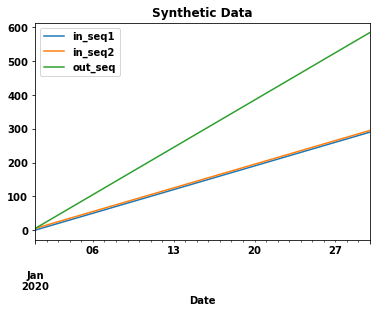

In [36]:
dataset.plot()
plt.title("Synthetic Data")

## Data Splitting
In Deep Learning, we will split the data into training and test dataset. The training data is used to train the model where the test data is used to validate the performance of the model.

In [37]:
# Calculate the split ratio 
split_data = round(len(dataset)*split_ratio)
split_data

21

In [38]:
# Split data by indexing 
train_data = dataset[:split_data]
test_data = dataset[split_data:]
train_time = dataset.index[:split_data]
test_time = dataset.index[split_data:]
print("train_data_shape")
print(train_data.shape)
print("test_data_shape")
print(test_data.shape)

train_data_shape
(21, 3)
test_data_shape
(9, 3)


## Data Standardization
Standardize your numeric attributes to have a 0 mean and unit variance.

In [39]:
# Build the standard scaler, Use to fit the train data and take the statistic of train data apply in test data
scaler = StandardScaler().fit(train_data.values.reshape(-1,1))
train_data_standard = scaler.transform(train_data.values.reshape(-1, 1))
test_data_standard = scaler.transform(test_data.values.reshape(-1, 1))

In [40]:
# Transform after scaling
train_data_standard = train_data_standard.reshape(train_data.shape[0],train_data.shape[1])
print("train_data_standardized"+str(train_data_standard.shape))

test_data_standard = test_data_standard.reshape(test_data.shape[0],test_data.shape[1])
print("test_data_standardized"+str(test_data_standard.shape))

train_data_standardized(21, 3)
test_data_standardized(9, 3)


## Data Sequencing
Sequencing the data by taking in the multivariate series into `x-feature` and `y-label`
<img src = "../../picture/multivariate univariate.png"  width="300" height  ="300" align="center" />

In [41]:
trainX, trainY = data_module.multivariate_univariate_multi_step(train_data_standard, window_size,n_step)
testX, testY = data_module.multivariate_univariate_multi_step(test_data_standard, window_size,n_step)
print(f"trainX shape:{trainX.shape} trainY shape:{trainY.shape}\n")
print(f"testX shape:{testX.shape} testY shape:{testY.shape}")

trainX shape:(16, 5, 2) trainY shape:(16, 2)

testX shape:(4, 5, 2) testY shape:(4, 2)


In [55]:
trainY = trainY.reshape(trainY.shape[0],n_step,1)
testY = testY.reshape(testY.shape[0],n_step,1)
print(f"trainY shape:{trainY.shape}")
print(f"testY shape:{testY.shape}")

trainY shape:(16, 2, 1)
testY shape:(4, 2, 1)


## Data Transform
Data need to transform from `NumPy` to `PyTorch` tensor before feeding into the model


In [56]:
train_data_dict ,test_data_dict = data_module.key_assign(trainingX = trainX  , 
                       testingX = testX, 
                       trainingY = trainY, 
                       testingY = testY)

train_data_dict ,test_data_dict = data_module.transform(train_data_dict ,test_data_dict)

In [57]:
data_module.sanity_check(train_data_dict , test_data_dict)

train_data_x_feature shape : torch.Size([16, 5, 2])
train_data_y_label shape : torch.Size([16, 2, 1])
test_data_x_feature shape : torch.Size([4, 5, 2])
test_data_y_label shape : torch.Size([4, 2, 1])


## Data Transpose 
You are require to transpose the x-feature data in a such a way that : <br>
>`(batch_size, number_of_features, sequence_length)`.

In [58]:
# Data Transpose to suit for CNN 
train_data_dict , test_data_dict= data_module.transpose(train_data_dict,test_data_dict)

In [59]:
data_module.sanity_check(train_data_dict , test_data_dict)

train_data_x_feature shape : torch.Size([16, 2, 5])
train_data_y_label shape : torch.Size([16, 2, 1])
test_data_x_feature shape : torch.Size([4, 2, 5])
test_data_y_label shape : torch.Size([4, 2, 1])


## Data Iterator
Iterator is created to allow the data separate into several batches to fasten the training process

In [60]:
train_iter , test_iter = data_module.iterator(train_data_dict ,test_data_dict,batch_size = batch_size)

# Step 2 :  CNN Model Configuration
You may choose to use the CNN configuration that have been save in the `deep_learning_module.py` or code it by yourself.

In [61]:
class CNN(nn.Module):

    def __init__(self,n_feature,n_step):
        super(CNN, self).__init__()
        
        self.n_feature = n_feature
        self.n_step = n_step

        # Conv1d in_channels is base on num time series
        # Input:(N,C,Lin) Output : (N,C,Lout)
        self.conv1 = nn.Conv1d(in_channels = n_feature, out_channels = 30, kernel_size = 2)
        
        # For example Input:(N,C,Lin) Output : (N,C,Lout)
        self.poo1 = nn.MaxPool1d(kernel_size=2)
        
        self.conv2 = nn.Conv1d(in_channels = 30, out_channels = 20, kernel_size = 2)
        
        # AdaptiveMaxPool1d use to make sure it always will output  = 1 ,to make sure return the correct batch size 
        self.pool2 = nn.AdaptiveMaxPool1d(1)
        self.fc1 = nn.Linear(20, 10)
        self.fc2 = nn.Linear(10,n_step)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.poo1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = x.view(-1,20)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x

## Input Model
The number of features and number of step feed as the attribute for the model. The other attribute such as `kernel_size` , `in_channels` and `out_channels` for each convolution layer need to configure in the network configuration by user.

In [62]:
# seed
torch.manual_seed(123)
### BEGIN SOLUTION
n_feature = train_data_dict['train_data_x_feature'].shape[1]

# Input the attribute need by the model 
model = CNN(n_feature = n_feature,n_step = n_step )

# Define the optimizer (Here we use SGD as our optimizer)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Define the loss function (Here we use MSE as the loss function)
loss_fn = nn.MSELoss()

### END SOLUTION

In [63]:
seq_length = train_data_dict['train_data_x_feature'].shape[2]
inputs = torch.zeros((batch_size,n_feature ,seq_length),dtype=torch.float) # batch size ,input_dim ,seq_length
print(summary(model,inputs))

        Kernel Shape Output Shape Params Mult-Adds
Layer                                             
0_conv1   [2, 30, 2]   [5, 30, 4]  150.0     480.0
1_poo1             -   [5, 30, 2]      -         -
2_conv2  [30, 20, 2]   [5, 20, 1]  1.22k      1.2k
3_pool2            -   [5, 20, 1]      -         -
4_fc1       [20, 10]      [5, 10]  210.0     200.0
5_fc2        [10, 2]       [5, 2]   22.0      20.0
----------------------------------------------------
                      Totals
Total params          1.602k
Trainable params      1.602k
Non-trainable params     0.0
Mult-Adds               1.9k
        Kernel Shape Output Shape  Params  Mult-Adds
Layer                                               
0_conv1   [2, 30, 2]   [5, 30, 4]   150.0      480.0
1_poo1             -   [5, 30, 2]     NaN        NaN
2_conv2  [30, 20, 2]   [5, 20, 1]  1220.0     1200.0
3_pool2            -   [5, 20, 1]     NaN        NaN
4_fc1       [20, 10]      [5, 10]   210.0      200.0
5_fc2        [10, 2]   

In [64]:
# seed
torch.manual_seed(123)

#  Xavier Weight Initialize 
def weights_init(m):
    if isinstance(m, nn.Conv1d):
        nn.init.xavier_uniform_(m.weight.data)
        
model.apply(weights_init)

CNN(
  (conv1): Conv1d(2, 30, kernel_size=(2,), stride=(1,))
  (poo1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(30, 20, kernel_size=(2,), stride=(1,))
  (pool2): AdaptiveMaxPool1d(output_size=1)
  (fc1): Linear(in_features=20, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=2, bias=True)
)

# Step 3 : Training

In [65]:
# Start Training
# seed
torch.manual_seed(123)
# Start Training
train_loss, val_loss = deep_learning_module.training(num_epochs, train_iter, test_iter, optimizer, loss_fn, model)

# Step 4 : Validation 
A learning curve is plotted to define how well the data is fitting the model 

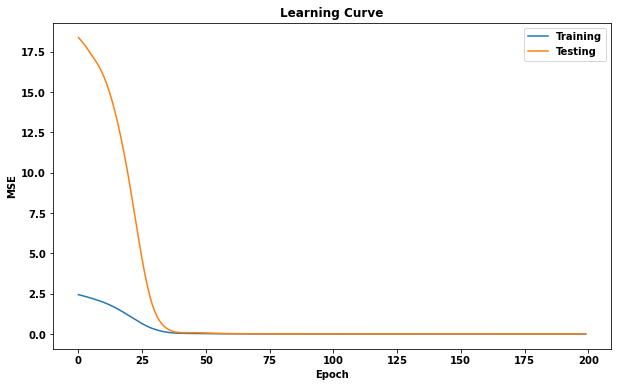

Epoch : 0 , training loss : 2.4388997107744217 , validation loss : 18.390308380126953
Epoch : 1 , training loss : 2.398174216039479 , validation loss : 18.20909881591797
Epoch : 2 , training loss : 2.3569496581330895 , validation loss : 18.013456344604492
Epoch : 3 , training loss : 2.313496005255729 , validation loss : 17.802152633666992
Epoch : 4 , training loss : 2.2679402204230428 , validation loss : 17.574291229248047
Epoch : 5 , training loss : 2.220036224462092 , validation loss : 17.332033157348633
Epoch : 6 , training loss : 2.1718964665196836 , validation loss : 17.10694694519043
Epoch : 7 , training loss : 2.122897682711482 , validation loss : 16.869060516357422
Epoch : 8 , training loss : 2.0707413707859814 , validation loss : 16.603933334350586
Epoch : 9 , training loss : 2.014545224606991 , validation loss : 16.307064056396484
Epoch : 10 , training loss : 1.9542933953925967 , validation loss : 15.953398704528809
Epoch : 11 , training loss : 1.8898042989894748 , validation

In [66]:
data_module.learning_curve(num_epochs = num_epochs , train_loss = train_loss , val_loss = val_loss )

# Step 5 : Evaluation
This section is to inference the model by feeding in testing data and determine the output forecast value and calculate the RMSE.

It consists of 4 sections :

Section 1 : Feed in the train and test data to the model <br>
Section 2 : Reshape both to the original data dimension <br> 
Section 3 : Invert the scaling back to the original data value <br>
Section 4 : Calculate the RMSE of train and test dataata

In [67]:
# Section 1 : make predictions
with torch.no_grad():
    y_train_prediction = model(train_data_dict['train_data_x_feature'])
    y_test_prediction = model(test_data_dict['test_data_x_feature'])

In [68]:
# Assign evaluation key

prediction , output = data_module.key_assign_evaluation(y_train_prediction,
                                                        y_test_prediction,
                                                        train_data_dict,
                                                        test_data_dict)
# Section 2 : Reshape to original data
# Squeeze the output dimension
output_data = data_module.squeeze_dimension(output)

In [69]:
data_module.sanity_check(data_1 = output_data,data_2 = {})

train_data_output shape : torch.Size([16, 2])
test_data_output shape : torch.Size([4, 2])


In [70]:
# Section 3 : Invert the scaling back to the original data value
prediction = data_module.inverse_scaler(prediction,scaler)
output_data  = data_module.inverse_scaler(output_data ,scaler)

In [71]:
# List the forecast value
data_module.list_forecast_value(output_data,prediction) 

Test Data			Forecast
[504.99997 525.     ]		[498.11374 523.51746]
[525. 545.]		[517.0457  543.25946]
[545. 565.]		[536.0177 563.042 ]
[565. 585.]		[555.06836 582.9043 ]


In [72]:
# Section 4 : Calculate the RMSE of train and test data
### BEGIN SOLUTION
trainScore,testScore = data_module.rmse(prediction,output_data)
### END SOLUTION
print('Train Score: %.2f RMSE' % (trainScore))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.94 RMSE
Test Score: 6.16 RMSE


# Step 6 : Forecast Plot

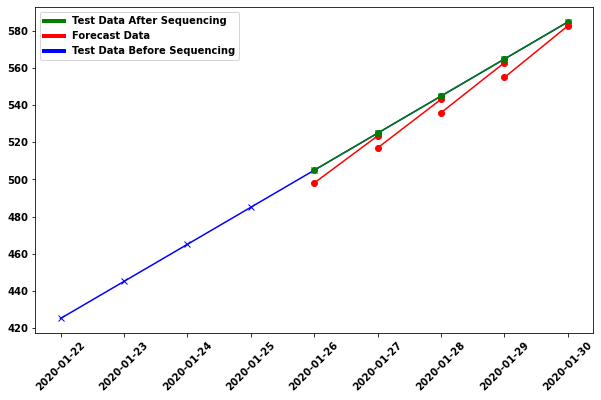

In [76]:
data_module.multi_step_plot(original_test_data = test_data["out_seq"],
                            after_sequence_test_data = output_data,
                            forecast_data = prediction,
                            test_time = test_time,
                            window_size = window_size,
                            n_step = n_step,
                            details={},
                            original_plot=True,
                            multivariate = True)


# Part 2 : Exercise for Multivariate Multi-step
## Task : Predict total number of death case in COVID-19 Malaysia 3 day in future

### Introduction 
You are given a set of data that contain information about COVID-19 cases worldwide. You are required to perform some data analysis on it and predict the death cases.<br>

Please follow the instruction and try to code the exercise.Please feel free to google to find out how to use a particular function in the data exploration part<br>



Data Source : 
https://www.kaggle.com/sudalairajkumar/novel-corona-virus-2019-dataset

## Hyperparameter
>**Instruction** : <br>
You are required to fill the `None` with a suitable value to make the model converge

>**Expected Result** : <br>
Train Score <= 10 RMSE<br>
Test Score <= 10 RMSE<br>

In [100]:
#Hyperameter
split_ratio_covid = 0.70
num_epochs_covid = 100
window_size_covid = 10
n_step_covid = 3
learning_rate_covid = 0.001
batch_size_covid = 5
#seed
torch.manual_seed(123)

# Step 1 : Data Preparation
In this tutorial, you will face a complex real-world dataset. You are required to use some of the data exploration technique to help you prepare the data.

>**Instruction** : <br>
Read the file using `pd.read_csv`<br>
Save your data as `cases`<br>
Your file path `../../datasets/others/covid_19_data.csv`

In [101]:
### BEGIN SOLUTION
cases = pd.read_csv("../../datasets/others/covid_19_data.csv")
### END SOLUTION
cases.head()

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
0,1,01/22/2020,Anhui,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
1,2,01/22/2020,Beijing,Mainland China,1/22/2020 17:00,14.0,0.0,0.0
2,3,01/22/2020,Chongqing,Mainland China,1/22/2020 17:00,6.0,0.0,0.0
3,4,01/22/2020,Fujian,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
4,5,01/22/2020,Gansu,Mainland China,1/22/2020 17:00,0.0,0.0,0.0


As you can see, the data contain info on COVID-19 cases from other countries as well. Hence you need to slice the COVID-19 info only for Malaysia.

>**Instruction** : <br>
Slice the COVID-19 info only for Malaysia. You might need to use `df.loc[]` to help you slice the data.

>**Expected Result** :<br>
Example of first 5 row data :

---	|SNo	|ObservationDate	|Province/State	|Country/Region	|Last Update	|Confirmed	|Deaths	|Recovered
 ---|---	|---	            |---	        |---	        |---	        |---	    |---	|---
78	|79	    |01/23/2020	|NaN	|Malaysia	|1/23/20 |17:00	|0.0	|0.0	|0.0
168	|169	|01/25/2020	|NaN	|Malaysia	|1/25/20 |17:00	|3.0	|0.0	|0.0
214	|215	|01/26/2020	|NaN	|Malaysia	|1/26/20 |16:00	|4.0	|0.0	|0.0
260	|261	|01/27/2020	|NaN	|Malaysia	|1/27/20 |23:59	|4.0	|0.0	|0.0
311	|312	|01/28/2020	|NaN	|Malaysia	|1/28/20 |23:00	|4.0	|0.0	|0.0

In [102]:
cases["Country/Region"].unique()

array(['Mainland China', 'Hong Kong', 'Macau', 'Taiwan', 'US', 'Japan',
       'Thailand', 'South Korea', 'Singapore', 'Philippines', 'Malaysia',
       'Vietnam', 'Australia', 'Mexico', 'Brazil', 'Colombia', 'France',
       'Nepal', 'Canada', 'Cambodia', 'Sri Lanka', 'Ivory Coast',
       'Germany', 'Finland', 'United Arab Emirates', 'India', 'Italy',
       'UK', 'Russia', 'Sweden', 'Spain', 'Belgium', 'Others', 'Egypt',
       'Iran', 'Israel', 'Lebanon', 'Iraq', 'Oman', 'Afghanistan',
       'Bahrain', 'Kuwait', 'Austria', 'Algeria', 'Croatia',
       'Switzerland', 'Pakistan', 'Georgia', 'Greece', 'North Macedonia',
       'Norway', 'Romania', 'Denmark', 'Estonia', 'Netherlands',
       'San Marino', ' Azerbaijan', 'Belarus', 'Iceland', 'Lithuania',
       'New Zealand', 'Nigeria', 'North Ireland', 'Ireland', 'Luxembourg',
       'Monaco', 'Qatar', 'Ecuador', 'Azerbaijan', 'Czech Republic',
       'Armenia', 'Dominican Republic', 'Indonesia', 'Portugal',
       'Andorra', 'Latvia

In [103]:
### BEGIN SOLUTION
new_covid_data = cases.loc[cases["Country/Region"] == 'Malaysia']
new_covid_data.head()
### END SOLUTION

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
78,79,01/23/2020,NaN,Malaysia,1/23/20 17:00,0.0,0.0,0.0
168,169,01/25/2020,NaN,Malaysia,1/25/20 17:00,3.0,0.0,0.0
214,215,01/26/2020,NaN,Malaysia,1/26/20 16:00,4.0,0.0,0.0
260,261,01/27/2020,NaN,Malaysia,1/27/20 23:59,4.0,0.0,0.0
311,312,01/28/2020,NaN,Malaysia,1/28/20 23:00,4.0,0.0,0.0


We need to make sure there is no missing value in our data
>**Instruction** : <br>
Use `df.isnull().values.any()` to check any missing data in our dataset. `True` is meant there is `NaN` in our dataset<br>
Most of the column does not contain `NaN` except for `Province/State ` . This is acceptable since this data does not useful to us and we will drop it later.

>**Expected Result** :<br>

Columns|Status
---|---
SNo                |False
ObservationDate    |False
Province/State      |True
Country/Region     |False
Last Update        |False
Confirmed          |False
Deaths             |False
Recovered          |False


In [104]:
### BEGIN SOLUTION
new_covid_data.isnull().any()
### END SOLUTION

SNo                False
ObservationDate    False
Province/State      True
Country/Region     False
Last Update        False
Confirmed          False
Deaths             False
Recovered          False
dtype: bool

>**Instruction** : <br>
Set the `ObservationDate` as the index for the dataset.You are required to convert `ObservationDate` to datetime using `pd.to_datetime()` <br>

>**Expected Result** :<br>
Example of first 5 row data :

ObservationDate	|SNo	|ObservationDate	|Province/State	|Country/Region	|Last Update	|Confirmed	|Deaths	|Recovered
 ---|---	|---	            |---	        |---	        |---	        |---	    |---	|---
01/23/2020	|79	    |01/23/2020	|NaN	|Malaysia	|1/23/20 |17:00	|0.0	|0.0	|0.0
01/25/2020	|169	|01/25/2020	|NaN	|Malaysia	|1/25/20 |17:00	|3.0	|0.0	|0.0
01/26/2020	|215	|01/26/2020	|NaN	|Malaysia	|1/26/20 |16:00	|4.0	|0.0	|0.0
01/27/2020	|261	|01/27/2020	|NaN	|Malaysia	|1/27/20 |23:59	|4.0	|0.0	|0.0
01/28/2020	|312	|01/28/2020	|NaN	|Malaysia	|1/28/20 |23:00	|4.0	|0.0	|0.0

In [105]:
### BEGIN SOLUTION
new_covid_data = new_covid_data.set_index(pd.to_datetime(new_covid_data["ObservationDate"]))
### END SOLUTION

new_covid_data.head()

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
ObservationDate,,,,,,,,
2020-01-23,79,01/23/2020,NaN,Malaysia,1/23/20 17:00,0.0,0.0,0.0
2020-01-25,169,01/25/2020,NaN,Malaysia,1/25/20 17:00,3.0,0.0,0.0
2020-01-26,215,01/26/2020,NaN,Malaysia,1/26/20 16:00,4.0,0.0,0.0
2020-01-27,261,01/27/2020,NaN,Malaysia,1/27/20 23:59,4.0,0.0,0.0
2020-01-28,312,01/28/2020,NaN,Malaysia,1/28/20 23:00,4.0,0.0,0.0


Columns such as `SNo`,`ObservationDate`,`Province/State`,`Country/Region`,`Last Update` does not provide any useful information to us . Hence we need to drop it to make the data looks cleaner. 

>**Instruction** : <br>
Use `df.drop` to drop the `columns = ['SNo','ObservationDate','Province/State','Country/Region','Last Update']`<br>

>**Expected Result** :<br>

ObservationDate	|Confirmed	|Deaths	|Recovered
	---|---|---|---		
2020-01-23|	0.0|	0.0|	0.0
2020-01-25|	3.0|	0.0|	0.0
2020-01-26|	4.0|	0.0|	0.0
2020-01-27|	4.0|	0.0|	0.0
2020-01-28|	4.0|    0.0|	0.0

In [106]:
### BEGIN SOLUTION
new_covid_data = new_covid_data.drop(columns = ['SNo','ObservationDate','Province/State','Country/Region','Last Update'])
### END SOLUTION
new_covid_data.head()

,Confirmed,Deaths,Recovered
ObservationDate,,,
2020-01-23,0.0,0.0,0.0
2020-01-25,3.0,0.0,0.0
2020-01-26,4.0,0.0,0.0
2020-01-27,4.0,0.0,0.0
2020-01-28,4.0,0.0,0.0


To make our window sliding function working. You need to rearrange the data columns such as the targeted forecast series will be the last column of the data
>**Instruction** : <br>
Rearrage the data column using `df[]`<br>
For example : <br>
columns = [`A`,`B`,`C`]<br>
rearrage columns = [`A`,`C`,`B`]<br>
`df =  df[rearrage columns]`

>**Expected Result** :<br>

ObservationDate|	Confirmed|	Recovered|	Deaths
		---|---|---|---	
2020-01-23|	0.0|	0.0|	0.0
2020-01-25|	3.0|	0.0|	0.0
2020-01-26|	4.0|	0.0|	0.0
2020-01-27|	4.0|	0.0|	0.0
2020-01-28|	4.0|	0.0|	0.0

In [107]:
### BEGIN SOLUTION
new_covid_data = new_covid_data[["Confirmed","Recovered","Deaths"]]
### END SOLUTION
new_covid_data.head()

,Confirmed,Recovered,Deaths
ObservationDate,,,
2020-01-23,0.0,0.0,0.0
2020-01-25,3.0,0.0,0.0
2020-01-26,4.0,0.0,0.0
2020-01-27,4.0,0.0,0.0
2020-01-28,4.0,0.0,0.0


## Data Visualization
Data visualization is importance for us to visualize the pattern of data such as trend and seasonality. As the graph below, it is shown that it is an increasing trend in data

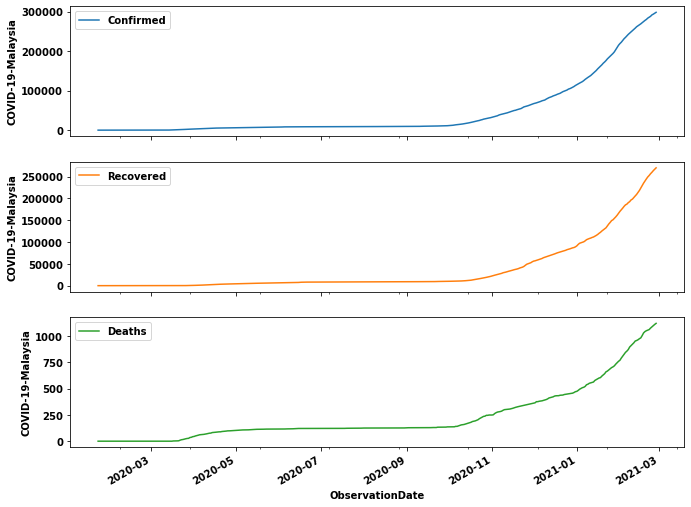

In [108]:
# Visualize Data 
axes = new_covid_data[new_covid_data.columns].plot(alpha=1.0, linestyle='-', figsize=(11, 9), subplots=True)
for ax in axes:
    ax.set_ylabel('COVID-19-Malaysia')

However, the data is in cumulative form. To perform time-series prediction, we need to convert the cumulative cases into daily cases.

>**Instruction** : <br>
Remove the cummulative. You might need to use a `For loop` to loop through the data for each columns .Use `new_covid_data[name] - new_covid_data[name].shift().fillna(0)` as the math operation to remove the cummulative<br>

>**Expected Result** :<br>

ObservationDate|	Confirmed|	Recovered|	Deaths|
	---|	---|---|---	
2020-01-23|	0.0|	0.0|	0.0|
2020-01-25|	3.0|	0.0|	0.0|
2020-01-26|	1.0|	0.0|	0.0|
2020-01-27|	0.0|	0.0|	0.0|
2020-01-28|	0.0|	0.0|	0.0|

In [109]:
### BEGIN SOLUTION
for name in new_covid_data.columns:
        new_covid_data[name] = new_covid_data[name] - new_covid_data[name].shift().fillna(0)
### END SOLUTION
new_covid_data.head()

,Confirmed,Recovered,Deaths
ObservationDate,,,
2020-01-23,0.0,0.0,0.0
2020-01-25,3.0,0.0,0.0
2020-01-26,1.0,0.0,0.0
2020-01-27,0.0,0.0,0.0
2020-01-28,0.0,0.0,0.0


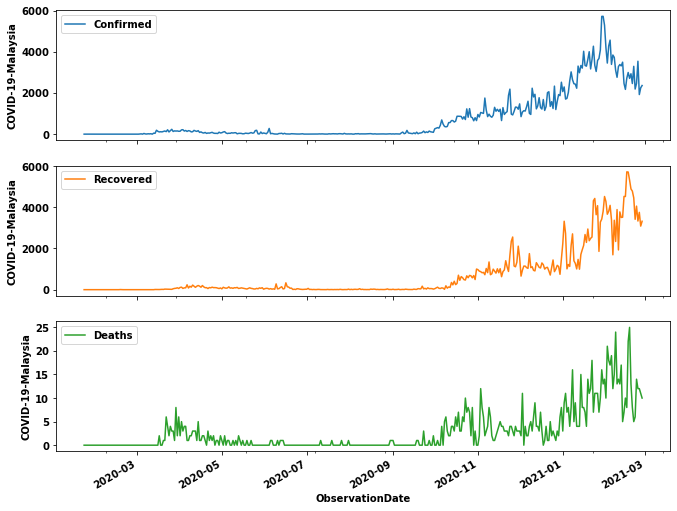

In [110]:
# Visualize Data 
axes = new_covid_data[new_covid_data.columns].plot(alpha=1.0, linestyle='-', figsize=(11, 9), subplots=True)
for ax in axes:
    ax.set_ylabel('COVID-19-Malaysia')

## Data Splitting
In Deep Learning, we will split the data into training and test dataset. The training data is used to train the model where the test data is used to validate the performance of the model.

In [111]:
split_data_covid = round(len(dataset)*split_ratio)
split_data_covid

21

In [112]:
# Split data by indexing 
train_data_covid = new_covid_data[:-split_data_covid ]
test_data_covid = new_covid_data[-split_data_covid :]
train_time_covid = new_covid_data.index[:-split_data_covid ]
test_time_covid = new_covid_data.index[-split_data_covid :]

print("train_data_shape")
print(train_data_covid.shape)
print("test_data_shape")
print(test_data_covid.shape)

train_data_shape
(380, 3)
test_data_shape
(21, 3)


## Data Normalization 
Normalize the data into range of 0 to 1

In [113]:
scaler_covid = MinMaxScaler().fit(train_data_covid.values.reshape(-1,1))
train_data_normalized_covid  = scaler_covid.transform(train_data_covid.values.reshape(-1, 1))
test_data_normalized_covid = scaler_covid.transform(test_data_covid.values.reshape(-1, 1))
print("train_data_normalized_demand"+str(train_data_normalized_covid.shape))
print("test_data_normalized_demand"+str(test_data_normalized_covid.shape))

train_data_normalized_demand(1140, 1)
test_data_normalized_demand(63, 1)


In [114]:
# Transform after scaling 
train_data_normalized_covid = train_data_normalized_covid.reshape(train_data_covid.shape[0],train_data_covid.shape[1])
print("test_data_normalized"+str(train_data_normalized_covid.shape))

test_data_normalized_covid = test_data_normalized_covid.reshape(test_data_covid.shape[0],test_data_covid.shape[1])
print("test_data_normalized"+str(test_data_normalized_covid.shape))

test_data_normalized(380, 3)
test_data_normalized(21, 3)


## Data Sequencing
Sequencing the data by taking in the multivariate series into x-feature and y-label
<img src = "../../picture/multivariate univariate.png"  width="300" height  ="300" align="center" />

In [115]:
trainX_covid ,trainY_covid=  data_module.multivariate_univariate_multi_step(train_data_normalized_covid,window_size_covid,n_step_covid)
testX_covid , testY_covid = data_module.multivariate_univariate_multi_step(test_data_normalized_covid,window_size_covid,n_step_covid)
print(f"trainX_demand shape:{trainX_covid.shape} trainY_demand shape:{trainY_covid.shape}\n")
print(f"testX_demand shape:{testX_covid.shape} testY_demand shape:{testY_covid.shape}")

trainX_demand shape:(369, 10, 2) trainY_demand shape:(369, 3)

testX_demand shape:(10, 10, 2) testY_demand shape:(10, 3)


In [116]:
trainY_covid = trainY_covid.reshape(trainY_covid.shape[0],n_step_covid,1)
testY_covid= testY_covid.reshape(testY_covid.shape[0],n_step_covid,1)
print(f"trainY shape:{trainY_covid.shape}")
print(f"testY shape:{testY_covid.shape}")

trainY shape:(369, 3, 1)
testY shape:(10, 3, 1)


### Data Transform
Data need to transform from numpy to pytorch tensor before feed into the model.

>**Instruction** : <br>
Use `data_module.key_assign` to assign the key and `data_module.transform` to transform the data.

In [117]:
### BEGIN SOLUTION
train_data_dict_covid ,test_data_dict_covid = data_module.key_assign(trainingX = trainX_covid  , 
                       testingX = testX_covid, 
                       trainingY = trainY_covid, 
                       testingY = testY_covid)
train_data_dict_covid ,test_data_dict_covid = data_module.transform(train_data_dict_covid ,test_data_dict_covid)
### END SOLUTION

In [118]:
data_module.sanity_check(train_data_dict_covid , test_data_dict_covid)

train_data_x_feature shape : torch.Size([369, 10, 2])
train_data_y_label shape : torch.Size([369, 3, 1])
test_data_x_feature shape : torch.Size([10, 10, 2])
test_data_y_label shape : torch.Size([10, 3, 1])


## Data Transpose 
You are require to transpose the x-feature data in a such a way that : <br>
>`(batch_size, number_of_features, sequence_length)`.


>**Instruction** : <br>
Use `transpose` function in `data_module.py` to transpose the suitable input data for CNN model.

In [122]:
train_data_dict_covid , test_data_dict_covid = data_module.transpose(train_data_dict_covid,
                                                                     test_data_dict_covid)

In [123]:
data_module.sanity_check(train_data_dict_covid , test_data_dict_covid)

train_data_x_feature shape : torch.Size([369, 2, 10])
train_data_y_label shape : torch.Size([369, 3, 1])
test_data_x_feature shape : torch.Size([10, 2, 10])
test_data_y_label shape : torch.Size([10, 3, 1])


## Data Iterator
Iterator is created to allow the data separate into several batches to fasten the training process
>**Instruction** : <br>
Use `data_module.iterator` to create data iterator.

In [124]:
### BEGIN SOLUTION
train_iter_covid , test_iter_covid = data_module.iterator(train_data_dict_covid ,
                                                          test_data_dict_covid,
                                                          batch_size = batch_size_covid)
### END SOLUTION

## Input Model

>**Instruction** : <br>
Input the model that you have configure

In [125]:
# seed
torch.manual_seed(123)

n_feature_covid = train_data_dict_covid['train_data_x_feature'].shape[1]
### BEGIN SOLUTION
# Input the attribute need by the model 
model_covid = CNN(n_feature = n_feature_covid,
                  n_step = n_step_covid )

### END SOLUTION

# Define the optimizer (Here we use Adam as our optimizer)
### BEGIN SOLUTION
optimizer_covid = torch.optim.Adam(model_covid.parameters(), lr=learning_rate_covid)
### END SOLUTION

# Define the loss function (Here we use MSE as the loss function)
### BEGIN SOLUTION
loss_fn_covid = nn.MSELoss()
### END SOLUTION

In [126]:
seq_length_covid = train_data_dict_covid['train_data_x_feature'].shape[2]

# batch size ,input_dim ,seq_length
inputs = torch.zeros((batch_size_covid,
                      n_feature_covid ,
                      seq_length_covid),dtype=torch.float) 

print(summary(model_covid,inputs))

        Kernel Shape Output Shape Params Mult-Adds
Layer                                             
0_conv1   [2, 30, 2]   [5, 30, 9]  150.0     1.08k
1_poo1             -   [5, 30, 4]      -         -
2_conv2  [30, 20, 2]   [5, 20, 3]  1.22k      3.6k
3_pool2            -   [5, 20, 1]      -         -
4_fc1       [20, 10]      [5, 10]  210.0     200.0
5_fc2        [10, 3]       [5, 3]   33.0      30.0
----------------------------------------------------
                      Totals
Total params          1.613k
Trainable params      1.613k
Non-trainable params     0.0
Mult-Adds              4.91k
        Kernel Shape Output Shape  Params  Mult-Adds
Layer                                               
0_conv1   [2, 30, 2]   [5, 30, 9]   150.0     1080.0
1_poo1             -   [5, 30, 4]     NaN        NaN
2_conv2  [30, 20, 2]   [5, 20, 3]  1220.0     3600.0
3_pool2            -   [5, 20, 1]     NaN        NaN
4_fc1       [20, 10]      [5, 10]   210.0      200.0
5_fc2        [10, 3]   

In [127]:
torch.manual_seed(123)

# Xavier weight intialization
def weights_init(m):
    if isinstance(m, nn.Conv1d):
        nn.init.xavier_uniform_(m.weight.data)
        
model_covid.apply(weights_init)

CNN(
  (conv1): Conv1d(2, 30, kernel_size=(2,), stride=(1,))
  (poo1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(30, 20, kernel_size=(2,), stride=(1,))
  (pool2): AdaptiveMaxPool1d(output_size=1)
  (fc1): Linear(in_features=20, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=3, bias=True)
)

# Step 3 : Training
>**Instruction** : <br>
Use `deep_learning_module.training` to train the model.

In [128]:
#seed
torch.manual_seed(123)
### BEGIN SOLUTION

# Start training 
train_loss_covid,val_loss_covid = deep_learning_module.training(num_epochs= num_epochs_covid ,
                                                    train_iter = train_iter_covid,
                                                    test_iter = test_iter_covid ,
                                                    optimizer = optimizer_covid,
                                                    loss_fn = loss_fn_covid,
                                                    model = model_covid)
### END SOLUTION

# Step 4 : Validation

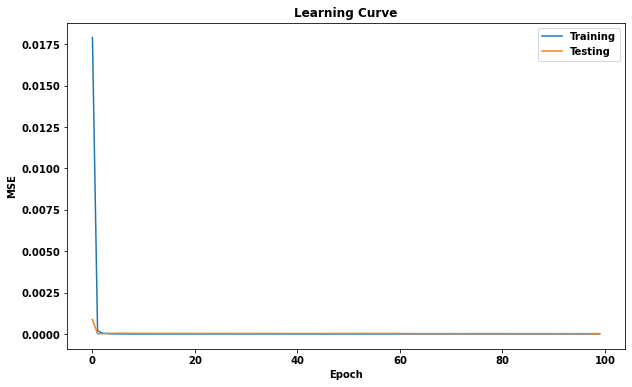

Epoch : 0 , training loss : 0.017914985473454503 , validation loss : 0.0008677042205817997
Epoch : 1 , training loss : 0.00019197204279299294 , validation loss : 1.3145560842531268e-05
Epoch : 2 , training loss : 4.805578873918194e-05 , validation loss : 1.9494360003591282e-05
Epoch : 3 , training loss : 1.892400673302271e-05 , validation loss : 3.5657587432069704e-05
Epoch : 4 , training loss : 8.930394606246843e-06 , validation loss : 4.349088703747839e-05
Epoch : 5 , training loss : 5.480725615694945e-06 , validation loss : 4.6482264224323444e-05
Epoch : 6 , training loss : 4.089781870201629e-06 , validation loss : 4.687286673288327e-05
Epoch : 7 , training loss : 3.3738806840884186e-06 , validation loss : 4.493790493143024e-05
Epoch : 8 , training loss : 2.9385452074178114e-06 , validation loss : 4.302582328818971e-05
Epoch : 9 , training loss : 2.692804934693288e-06 , validation loss : 4.1526276618242264e-05
Epoch : 10 , training loss : 2.5585814555086942e-06 , validation loss : 4

In [129]:
# Plot Learning Curve 
### BEGIN SOLUTION
data_module.learning_curve(num_epochs = num_epochs_covid,
                           train_loss = train_loss_covid ,
                           val_loss = val_loss_covid)

### END SOLUTION

# Step 5 : Evaluation
This section is to inference the model by feeding in testing data and determine the output forecast value and calculate the RMSE. For this exercise, use the function in `data_module` to run in each section.

It consists of 4 sections :

Section 1 : Feed in the train and test data to the model <br>
Section 2 : Reshape both to the original data dimension <br> 
Section 3 : Invert the scaling back to the original data value <br>
Section 4 : Calculate the RMSE of train and test data

>**Instruction** : <br>
Complete each sections with the function in `data_module.py`

In [131]:
# Section 1 : Make predictions

### BEGIN SOLUTION
with torch.no_grad():
    y_train_prediction_covid = model_covid(train_data_dict_covid['train_data_x_feature'])
    y_test_prediction_covid = model_covid(test_data_dict_covid['test_data_x_feature'])
### END SOLUTION

In [132]:
# Assign evaluation key
### BEGIN SOLUTION
prediction_covid , output_covid = data_module.key_assign_evaluation(y_train_prediction_covid,
                                                                    y_test_prediction_covid,
                                                                    train_data_dict_covid,
                                                                    test_data_dict_covid)
### END SOLUTION


# Section 2 : Reshape data
### BEGIN SOLUTION
# Squeeze the output dimension
output_data_covid = data_module.squeeze_dimension(output_covid)
### END SOLUTION

In [133]:
data_module.sanity_check(data_1 = output_data_covid,data_2 = {})

train_data_output shape : torch.Size([369, 3])
test_data_output shape : torch.Size([10, 3])


In [134]:
# Section 3 : Invert the scaling back to orignal data value
### BEGIN SOLUTION
prediction_covid = data_module.inverse_scaler(prediction_covid,scaler_covid)
output_data_covid  = data_module.inverse_scaler(output_data_covid ,scaler_covid)
### END SOLUTION

`np.rint` is use to round our data to integer since the death cases should be in the integer form

In [135]:
prediction_covid['test_data_prediction'] = np.rint(prediction_covid['test_data_prediction'])
output_data_covid['test_data_output'] =  np.rint(output_data_covid['test_data_output']) 

In [136]:
# List the forecast value
### BEGIN SOLUTION
data_module.list_forecast_value(output_data_covid,prediction_covid) 
### END SOLUTION

Test Data			Forecast
[ 8. 22. 25.]		[ 6.  7. 14.]
[22. 25. 13.]		[ 3.  4. 17.]
[25. 13.  8.]		[19. 23. 20.]
[13.  8.  5.]		[ 8.  8. 23.]
[8. 5. 6.]		[39. 52. 22.]
[ 5.  6. 14.]		[37. 44. 27.]
[ 6. 14. 12.]		[49. 63. 30.]
[14. 12. 12.]		[60. 72. 32.]
[12. 12. 11.]		[26. 34. 28.]
[12. 11. 10.]		[35. 49. 24.]


In [137]:
# calculate root mean squared error
### BEGIN SOLUTION
trainScore_covid,testScore_covid = data_module.rmse(prediction_covid,output_data_covid)
print('Train Score: %.2f RMSE' % (trainScore_covid))
print('Test Score: %.2f RMSE' % (testScore_covid))
### END SOLUTION

Train Score: 21.45 RMSE
Test Score: 26.89 RMSE


# Step 6 : Forecast Plot

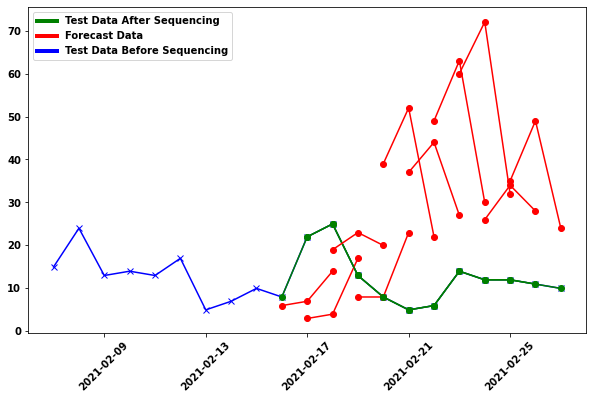

In [139]:
data_module.multi_step_plot(original_test_data = test_data_covid["Deaths"],
                            after_sequence_test_data = output_data_covid,
                            forecast_data = prediction_covid,
                            test_time = test_time_covid,
                            window_size = window_size_covid,
                            n_step = n_step_covid,
                            details={},
                            original_plot=True,
                            multivariate = True)


## Summary
In this tutorial you should have learned:

1. The flow of using CNN to perform multivariate input , univariate output multi-step forecasting<br>

Congratulations, that concludes this lesson.<br>




1. ~~*[04 - CNN- Univariate - Single-Step]*~~ *Complete*
2. ~~*[04 - CNN-Univariate-Multi-Step]*~~*Complete*
3. ~~*[04 - CNN-Multivariate-Univariate-Single-Step]*~~*Complete*
4. ~~*[04 - CNN-Multivariate-Univariate-Multi-Step]*~~*Complete*

## Reference
1. [Deep Learning for Time Series Forecasting (Predict the Future with MLPs,CNNs and LSTMs in Python) , Jason Brownlee](https://machinelearningmastery.com/deep-learning-for-time-series-forecasting/)
